In [1]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch
from matplotlib import pyplot as plt

from src.models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP

In [2]:
data_name = "DS03"
perform_name = 'SmHPC'

device = "cpu"
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data

In [3]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### get only degraded data

In [4]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [5]:
perform_alias = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].astype(int).unique().tolist()
units

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
performs_train = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_alias
}
time_train = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Create component (base) models

In [7]:


eval_data = {}
eval_eol = {}
for unit in units:
    t_data = time_train[unit]
    s_data = performs_train[perform_name][unit]
    eval_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32).to(device)
    eval_eol[unit]=torch.tensor(t_data[-1],dtype=torch.float32) 


In [8]:
train_degmodels = {}
for eval_unit in units:
    degmodels=[]
    for unit, perform in performs_train[perform_name].items():
        if unit == eval_unit:
            continue
        best_model = NModel()
        best_model.load_state_dict(
            torch.load(states_dir /perform_name/f'unit_{unit}'/ "best_model.pt", map_location=device)
        )
        best_model.to(device)
        degmodels.append(best_model)
    train_degmodels[eval_unit] = degmodels

## Train Particle Filter Net

In [ ]:
n_particles = 1600
multiply_scale = 0.5
start_idx = 5 

n_epochs = 5000
acc_epochs = 1

In [10]:
net = ParticleFilterMLP(state_dim=5, hidden_dims=[128, 128, 32]).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer.zero_grad()


losses = []
epochs = []
total_loss = 0.0
best_loss = float("inf")
for epoch in range(n_epochs):

    epoch_loss = 0.0
    n_loss = 0
    for eval_unit in units:
        degmodels = train_degmodels[eval_unit]
        t_data = eval_data[eval_unit][:, 0]
        s_data = eval_data[eval_unit][:, 1]

        pf = ParticleFilterModel(
            base_models=degmodels,
            net=net,
            max_life=100.0,
            n_particles=n_particles,
            multiply_scale=multiply_scale,
            name=perform_name,
        ).train()

        for k in range(start_idx, len(t_data)):
            mixture_dist = pf.step(
                t_obs=t_data[:k],
                s_obs=s_data[:k],
            )
            last_dist = mixture_dist.distribution(s=s_data[[-1]])
            nll = -last_dist.log_prob(t_data[[-1]]).mean()

            epoch_loss += nll
            n_loss += 1

    # ---- normalize THIS epoch’s contribution ----
    epoch_loss = epoch_loss / n_loss

    # ---- accumulate gradient ----
    total_loss += epoch_loss

    # ---- step every acc_epochs ----
    if (epoch + 1) % acc_epochs == 0:
        total_loss /= acc_epochs
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"[Epoch {epoch:04d}] loss = {total_loss.item():.3f}")
        losses.append(total_loss.item())
        epochs.append(epoch)
        
        total_loss = 0.0

        # ---- save best model ----
        if epoch_loss.item() < best_loss:
            best_loss = epoch_loss.item()
            torch.save(
                net.state_dict(),
                states_dir / perform_name / "best_pf_net.pt",
            )
            print("  + saved ")

[Epoch 0000] loss = 3.773
  + saved 
[Epoch 0001] loss = 3.749
  + saved 
[Epoch 0002] loss = 3.779
[Epoch 0003] loss = 3.772
[Epoch 0004] loss = 3.737
  + saved 
[Epoch 0005] loss = 3.749
[Epoch 0006] loss = 3.746
[Epoch 0007] loss = 3.763
[Epoch 0008] loss = 3.786
[Epoch 0009] loss = 3.750
[Epoch 0010] loss = 3.753
[Epoch 0011] loss = 3.757
[Epoch 0012] loss = 3.735
  + saved 
[Epoch 0013] loss = 3.741
[Epoch 0014] loss = 3.754
[Epoch 0015] loss = 3.734
  + saved 
[Epoch 0016] loss = 3.749
[Epoch 0017] loss = 3.739
[Epoch 0018] loss = 3.746
[Epoch 0019] loss = 3.763
[Epoch 0020] loss = 3.724
  + saved 
[Epoch 0021] loss = 3.756
[Epoch 0022] loss = 3.774
[Epoch 0023] loss = 3.728
[Epoch 0024] loss = 3.750
[Epoch 0025] loss = 3.764
[Epoch 0026] loss = 3.766
[Epoch 0027] loss = 3.745
[Epoch 0028] loss = 3.728
[Epoch 0029] loss = 3.703
  + saved 
[Epoch 0030] loss = 3.716
[Epoch 0031] loss = 3.714
[Epoch 0032] loss = 3.706
[Epoch 0033] loss = 3.729
[Epoch 0034] loss = 3.681
  + saved 
[E

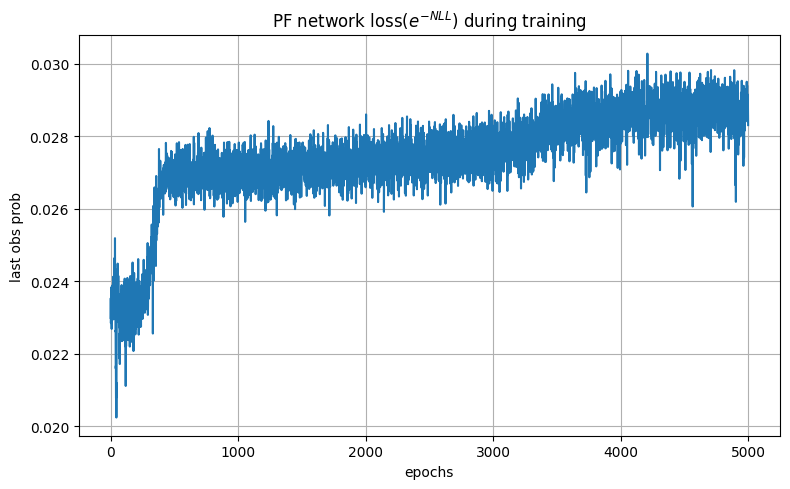

In [11]:
likelihood = np.exp(-np.array(losses))

plt.figure(figsize=(8, 5))
plt.plot(epochs, likelihood)
plt.xlabel('epochs')
plt.ylabel('last obs prob')
plt.title('PF network loss($e^{-NLL}$) during training')
plt.grid(True)

plt.tight_layout()
plt.savefig(states_dir /perform_name/"net_training_loss.png", dpi=300) 
np.save(states_dir /perform_name/"net_training_loss.npy", np.array(losses))
plt.show()